In [1]:
import sqlite3
import csv

csv_file_path = 'heart.csv'
db_file_path = 'heart.db'

conn = sqlite3.connect(db_file_path)
cursor = conn.cursor()

# Drop tables if they exist
cursor.execute("DROP TABLE IF EXISTS patients;")
cursor.execute("DROP TABLE IF EXISTS measurements;")
cursor.execute("DROP TABLE IF EXISTS diagnosis;")

# Create normalized tables
cursor.execute("""
CREATE TABLE patients (
    patient_id INTEGER PRIMARY KEY,
    age INTEGER,
    sex TEXT
);
""")

cursor.execute("""
CREATE TABLE measurements (
    meas_id INTEGER PRIMARY KEY AUTOINCREMENT,
    patient_id INTEGER,
    trestbps INTEGER,
    chol INTEGER,
    fbs INTEGER,
    restecg INTEGER,
    thalach INTEGER,
    exang INTEGER,
    oldpeak REAL,
    slope INTEGER,
    ca INTEGER,
    thal INTEGER,
    FOREIGN KEY(patient_id) REFERENCES patients(patient_id)
);
""")

cursor.execute("""
CREATE TABLE diagnosis (
    diag_id INTEGER PRIMARY KEY AUTOINCREMENT,
    patient_id INTEGER,
    cp_type INTEGER,
    target INTEGER,
    FOREIGN KEY(patient_id) REFERENCES patients(patient_id)
);
""")

with open(csv_file_path, 'r', newline='', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    header = next(reader)  # Read header row
    # Print the header to see what columns are available
    print("CSV Header:", header)

    # Based on a typical heart dataset, you might have columns like:
    # age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
    # Adjust column indices accordingly:
    age_idx = header.index("age")
    sex_idx = header.index("sex")
    cp_idx = header.index("cp")
    trestbps_idx = header.index("trestbps")
    chol_idx = header.index("chol")
    fbs_idx = header.index("fbs")
    restecg_idx = header.index("restecg")
    thalach_idx = header.index("thalach")
    exang_idx = header.index("exang")
    oldpeak_idx = header.index("oldpeak")
    slope_idx = header.index("slope")
    ca_idx = header.index("ca")
    thal_idx = header.index("thal")
    target_idx = header.index("target")

    row_number = 1  # We'll use this to generate a surrogate patient_id

    for row in reader:
        patient_id_val = row_number
        age_val = int(row[age_idx])
        sex_val = row[sex_idx]
        cp_val = int(row[cp_idx])
        trestbps_val = int(row[trestbps_idx])
        chol_val = int(row[chol_idx])
        fbs_val = int(row[fbs_idx])
        restecg_val = int(row[restecg_idx])
        thalach_val = int(row[thalach_idx])
        exang_val = int(row[exang_idx])
        oldpeak_val = float(row[oldpeak_idx])
        slope_val = int(row[slope_idx])
        ca_val = int(row[ca_idx])
        thal_val = int(row[thal_idx])
        target_val = int(row[target_idx])

        # Insert into patients table
        cursor.execute("""
            INSERT INTO patients (patient_id, age, sex)
            VALUES (?, ?, ?)
        """, (patient_id_val, age_val, sex_val))

        # Insert into measurements table
        cursor.execute("""
            INSERT INTO measurements (
                patient_id, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        """, (patient_id_val, trestbps_val, chol_val, fbs_val, restecg_val, thalach_val, exang_val, oldpeak_val, slope_val, ca_val, thal_val))

        # Insert into diagnosis table
        cursor.execute("""
            INSERT INTO diagnosis (patient_id, cp_type, target)
            VALUES (?, ?, ?)
        """, (patient_id_val, cp_val, target_val))

        row_number += 1

conn.commit()
conn.close()

print("Database created and populated successfully.")


CSV Header: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
Database created and populated successfully.


In [2]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
db_file_path = 'heart.db'  # Path to the SQLite database
conn = sqlite3.connect(db_file_path)

# SQL query to join tables and reconstruct the data
query = """
SELECT
    patients.patient_id,
    patients.age,
    patients.sex,
    measurements.trestbps,
    measurements.chol,
    measurements.fbs,
    measurements.restecg,
    measurements.thalach,
    measurements.exang,
    measurements.oldpeak,
    measurements.slope,
    measurements.ca,
    measurements.thal,
    diagnosis.cp_type,
    diagnosis.target
FROM
    patients
JOIN
    measurements ON patients.patient_id = measurements.patient_id
JOIN
    diagnosis ON patients.patient_id = diagnosis.patient_id;
"""

# Execute the query and load the data into a Pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Display the first few rows of the DataFrame
print(df.head())



   patient_id  age sex  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0           1   52   1       125   212    0        1      168      0      1.0   
1           2   53   1       140   203    1        0      155      1      3.1   
2           3   70   1       145   174    0        1      125      1      2.6   
3           4   61   1       148   203    0        1      161      0      0.0   
4           5   62   0       138   294    1        1      106      0      1.9   

   slope  ca  thal  cp_type  target  
0      2   2     3        0       0  
1      0   0     3        0       0  
2      0   0     3        0       0  
3      2   1     3        0       0  
4      1   3     2        0       0  


In [4]:
import mlflow
import os

# Step 1: Set the tracking URI
mlflow.set_tracking_uri("https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow")

# Step 2: Set your DagsHub access token in the environment variables
os.environ["MLFLOW_TRACKING_USERNAME"] = "Sudeepthi-Rongali"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "b8cf8553047a54065934eb49226ab0205416e911"

# Step 3: Create or set the experiment
experiment_name = "Heart Disease Prediction Experiments"

# Check if the experiment exists; otherwise, create it
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    print(f"Experiment '{experiment_name}' not found. Creating a new experiment...")
    mlflow.create_experiment(experiment_name)

mlflow.set_experiment(experiment_name)

# Step 4: Log a test experiment to verify connectivity
with mlflow.start_run(run_name="Test_Run"):
    mlflow.log_param("model", "Random Forest Classifier")
    mlflow.log_param("max_depth", 10)
    mlflow.log_metric("accuracy", 0.92)
    mlflow.log_metric("f1_score", 0.89)
    mlflow.set_tag("project", "Heart Disease Prediction")

print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment '{experiment_name}' is ready for logging.")


🏃 View run Test_Run at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0/runs/8821e15c2116406b9a923dc6316c4268
🧪 View experiment at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0
MLflow tracking URI: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow
Experiment 'Heart Disease Prediction Experiments' is ready for logging.


In [9]:
import mlflow

# Start an MLflow run
with mlflow.start_run(run_name="Data Preprocessing"):
    # Step 1: Rename columns for better clarity
    df.rename(
        columns={
            'age': 'Age',
            'sex': 'Sex',
            'trestbps': 'RestingBP',
            'chol': 'Cholesterol',
            'fbs': 'FastingBS',
            'restecg': 'RestingECG',
            'thalach': 'MaxHR',
            'exang': 'ExerciseAngina',
            'oldpeak': 'OldPeak',
            'slope': 'ST_Slope',
            'ca': 'MajorVessels',
            'thal': 'Thalassemia',
            'cp_type': 'ChestPainType',
            'target': 'Target'
        },
        inplace=True
    )
    print("Columns renamed successfully.")
    mlflow.log_param("Columns Renamed", "True")

    # Step 2: Check for missing values
    missing_values = df.isnull().sum()
    print("Missing values in each column:")
    print(missing_values)
    mlflow.log_metric("Total Missing Values", missing_values.sum())

    # Step 3: Ensure data types are consistent and correct
    print("\nData types before correction:")
    print(df.dtypes)
    mlflow.log_param("Data Types Before Correction", str(df.dtypes.to_dict()))

    # Example: Convert columns to appropriate types (if needed)
    df['Sex'] = df['Sex'].astype(int)
    df['FastingBS'] = df['FastingBS'].astype(int)
    df['ChestPainType'] = df['ChestPainType'].astype(int)
    df['Target'] = df['Target'].astype(int)

    print("\nData types after correction:")
    print(df.dtypes)
    mlflow.log_param("Data Types After Correction", str(df.dtypes.to_dict()))

    # Display the cleaned DataFrame
    print("\nCleaned DataFrame:")
    print(df.head())

    # Log the cleaned DataFrame as an artifact
    cleaned_data_path = "cleaned_heart_disease.csv"
    df.to_csv(cleaned_data_path, index=False)
    mlflow.log_artifact(cleaned_data_path)
    print(f"\nCleaned DataFrame saved as {cleaned_data_path} and logged to DagsHub.")


Columns renamed successfully.
Missing values in each column:
patient_id        0
Age               0
Sex               0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
OldPeak           0
ST_Slope          0
MajorVessels      0
Thalassemia       0
ChestPainType     0
Target            0
dtype: int64

Data types before correction:
patient_id          int64
Age                 int64
Sex                object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG          int64
MaxHR               int64
ExerciseAngina      int64
OldPeak           float64
ST_Slope            int64
MajorVessels        int64
Thalassemia         int64
ChestPainType       int64
Target              int64
dtype: object

Data types after correction:
patient_id          int64
Age                 int64
Sex                 int64
RestingBP           int64
Cholesterol         int64
FastingBS           int64
Resti

Summary statistics:
        patient_id          Age          Sex    RestingBP  Cholesterol  \
count  1025.000000  1025.000000  1025.000000  1025.000000   1025.00000   
mean    513.000000    54.434146     0.695610   131.611707    246.00000   
std     296.036315     9.072290     0.460373    17.516718     51.59251   
min       1.000000    29.000000     0.000000    94.000000    126.00000   
25%     257.000000    48.000000     0.000000   120.000000    211.00000   
50%     513.000000    56.000000     1.000000   130.000000    240.00000   
75%     769.000000    61.000000     1.000000   140.000000    275.00000   
max    1025.000000    77.000000     1.000000   200.000000    564.00000   

         FastingBS   RestingECG        MaxHR  ExerciseAngina      OldPeak  \
count  1025.000000  1025.000000  1025.000000     1025.000000  1025.000000   
mean      0.149268     0.529756   149.114146        0.336585     1.071512   
std       0.356527     0.527878    23.005724        0.472772     1.175053   
min  

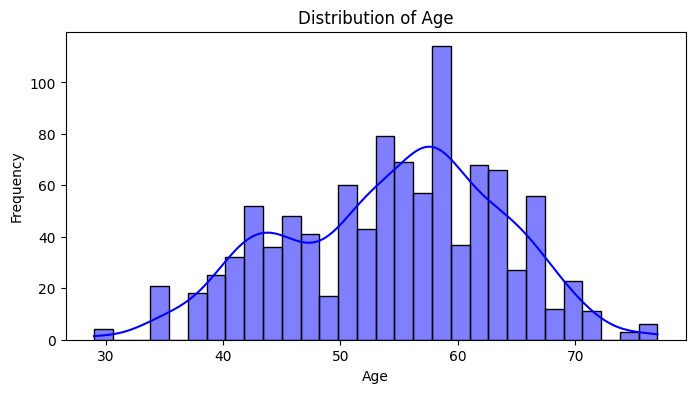

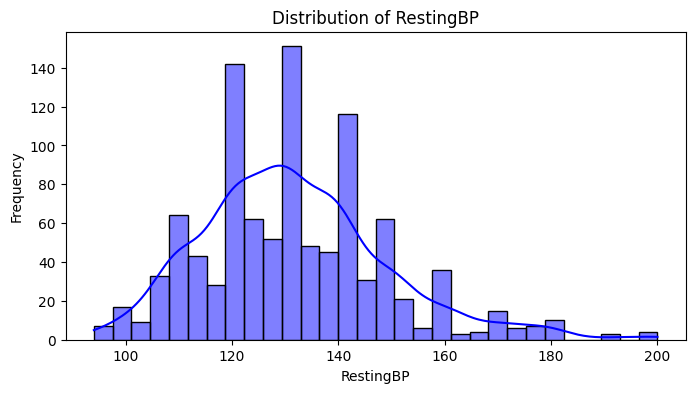

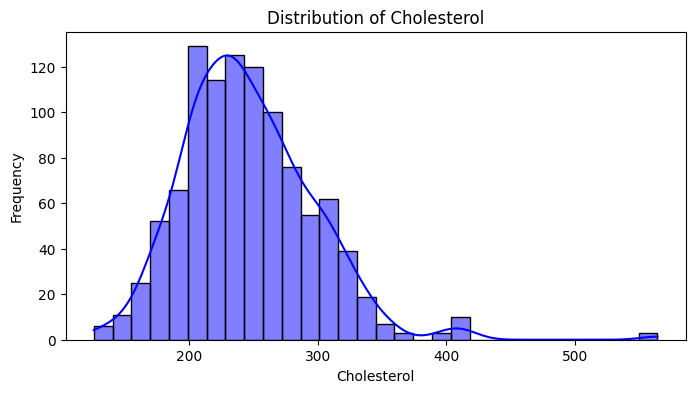

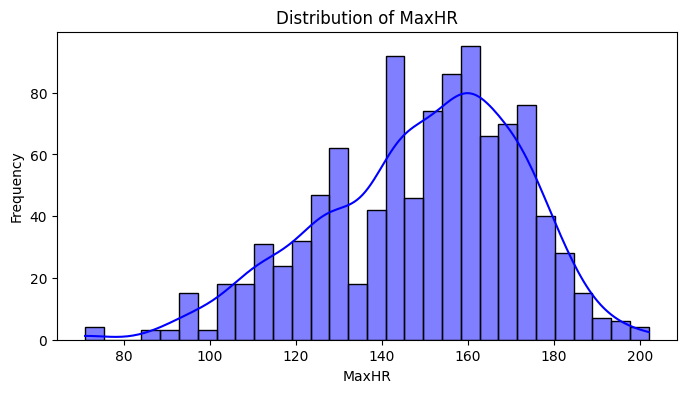

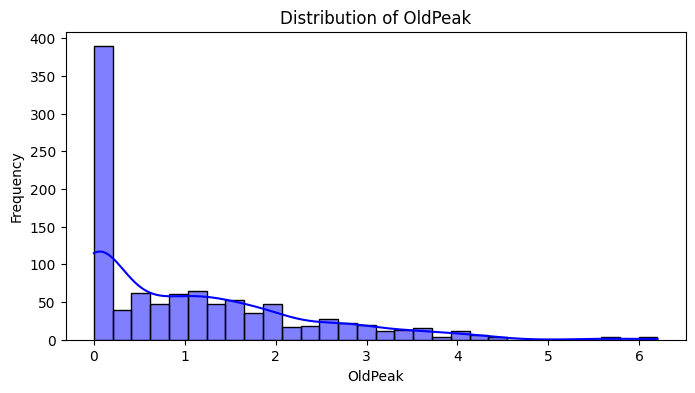


EDA and visualizations logged to DagsHub successfully!
🏃 View run EDA and Visualization at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0/runs/342885e62907420a8ffa177f73646b40
🧪 View experiment at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

# Start an MLflow run
with mlflow.start_run(run_name="EDA and Visualization"):
    # Descriptive statistics
    print("Summary statistics:")
    summary_stats = df.describe()
    print(summary_stats)
    # Log descriptive statistics as a CSV artifact
    summary_stats_path = "summary_statistics.csv"
    summary_stats.to_csv(summary_stats_path)
    mlflow.log_artifact(summary_stats_path)

    # Count the distribution of the target variable
    print("\nTarget variable distribution:")
    target_distribution = df['Target'].value_counts()
    print(target_distribution)
    # Log target variable distribution as a parameter
    mlflow.log_param("Target Distribution", target_distribution.to_dict())

    # Visualizing the distribution of numerical variables
    numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'OldPeak']

    # Plot histograms for numerical columns
    for column in numerical_columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[column], kde=True, bins=30, color="blue")
        plt.title(f"Distribution of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        
        # Save the plot and log it as an artifact
        plot_path = f"{column}_distribution.png"
        plt.savefig(plot_path)
        plt.show()
        mlflow.log_artifact(plot_path)

    print("\nEDA and visualizations logged to DagsHub successfully!")


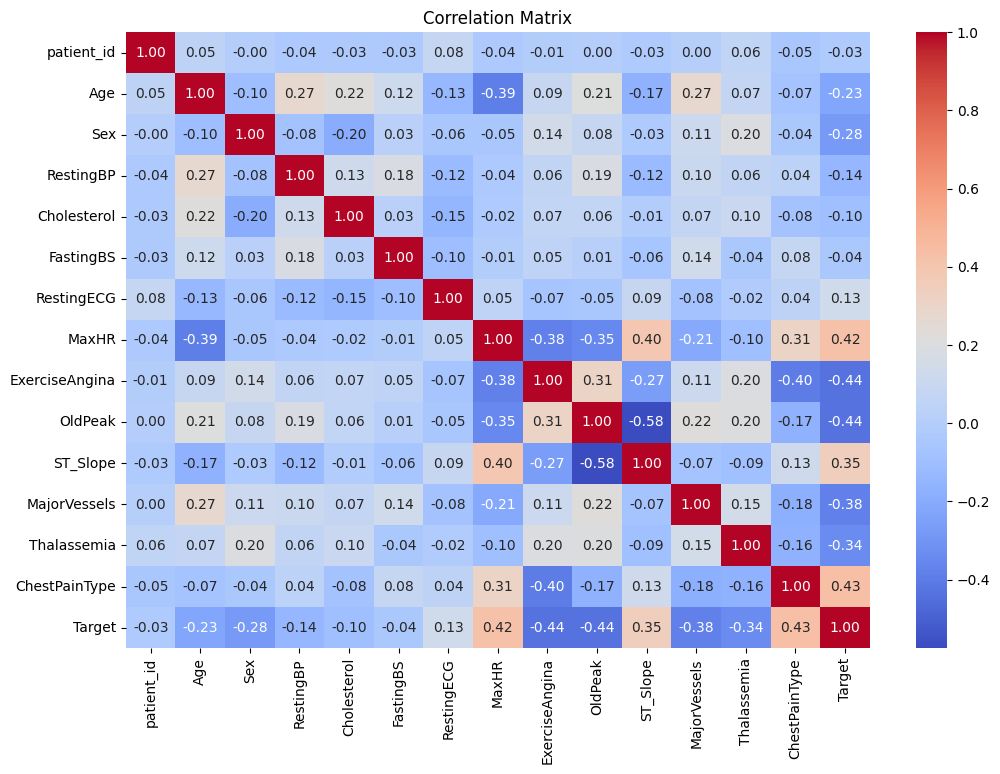

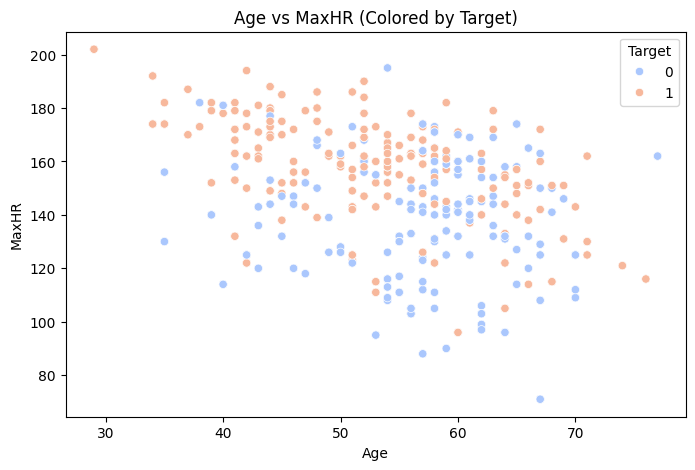

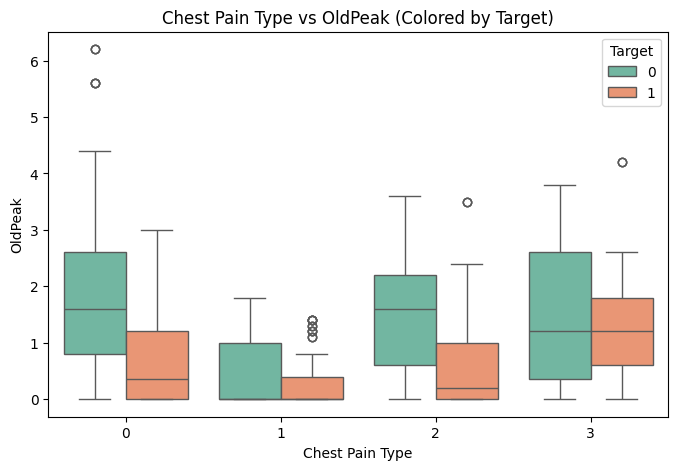


Correlation and visualizations logged to DagsHub successfully!
🏃 View run Correlation and Visualizations at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0/runs/6a1e5a7e2ddb44c68f287cafc8f92ac0
🧪 View experiment at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

# Start an MLflow run
with mlflow.start_run(run_name="Correlation and Visualizations"):
    # Heatmap to show correlations
    plt.figure(figsize=(12, 8))
    correlation_matrix = df.corr()

    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix")
    # Save and show heatmap
    heatmap_path = "correlation_matrix.png"
    plt.savefig(heatmap_path)
    plt.show()
    mlflow.log_artifact(heatmap_path)

    # Scatter plot: Age vs MaxHR
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x='Age', y='MaxHR', hue='Target', palette='coolwarm')
    plt.title("Age vs MaxHR (Colored by Target)")
    plt.xlabel("Age")
    plt.ylabel("MaxHR")
    plt.legend(title='Target')
    # Save and show scatter plot
    scatterplot_path = "age_vs_maxhr.png"
    plt.savefig(scatterplot_path)
    plt.show()
    mlflow.log_artifact(scatterplot_path)

    # Boxplot: ChestPainType vs Target
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='ChestPainType', y='OldPeak', hue='Target', palette='Set2')
    plt.title("Chest Pain Type vs OldPeak (Colored by Target)")
    plt.xlabel("Chest Pain Type")
    plt.ylabel("OldPeak")
    plt.legend(title='Target')
    # Save and show boxplot
    boxplot_path = "chestpain_vs_oldpeak.png"
    plt.savefig(boxplot_path)
    plt.show()
    mlflow.log_artifact(boxplot_path)

    print("\nCorrelation and visualizations logged to DagsHub successfully!")


In [12]:
from sklearn.model_selection import train_test_split
import mlflow

# Start an MLflow run
with mlflow.start_run(run_name="Train-Test Split"):
    # Check the distribution of the target variable
    print("Distribution of Target in the entire dataset:")
    target_distribution = df['Target'].value_counts(normalize=True)
    print(target_distribution)
    mlflow.log_param("Overall Target Distribution", target_distribution.to_dict())

    # Perform stratified train/test split to maintain class balance
    X = df.drop(columns=['Target', 'patient_id'])  # Exclude the target and patient ID
    y = df['Target']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Verify the class distribution in the train and test splits
    train_distribution = y_train.value_counts(normalize=True)
    test_distribution = y_test.value_counts(normalize=True)

    print("\nDistribution of Target in the training set:")
    print(train_distribution)
    mlflow.log_param("Train Target Distribution", train_distribution.to_dict())

    print("\nDistribution of Target in the test set:")
    print(test_distribution)
    mlflow.log_param("Test Target Distribution", test_distribution.to_dict())

    # Save the train and test splits as artifacts
    X_train.to_csv("X_train.csv", index=False)
    X_test.to_csv("X_test.csv", index=False)
    y_train.to_csv("y_train.csv", index=False)
    y_test.to_csv("y_test.csv", index=False)

    mlflow.log_artifact("X_train.csv")
    mlflow.log_artifact("X_test.csv")
    mlflow.log_artifact("y_train.csv")
    mlflow.log_artifact("y_test.csv")

    print("\nTrain-test split logged to DagsHub successfully!")


Distribution of Target in the entire dataset:
Target
1    0.513171
0    0.486829
Name: proportion, dtype: float64

Distribution of Target in the training set:
Target
1    0.513415
0    0.486585
Name: proportion, dtype: float64

Distribution of Target in the test set:
Target
1    0.512195
0    0.487805
Name: proportion, dtype: float64

Train-test split logged to DagsHub successfully!
🏃 View run Train-Test Split at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0/runs/7352229dbae24a85b735fd4e479a2528
🧪 View experiment at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0


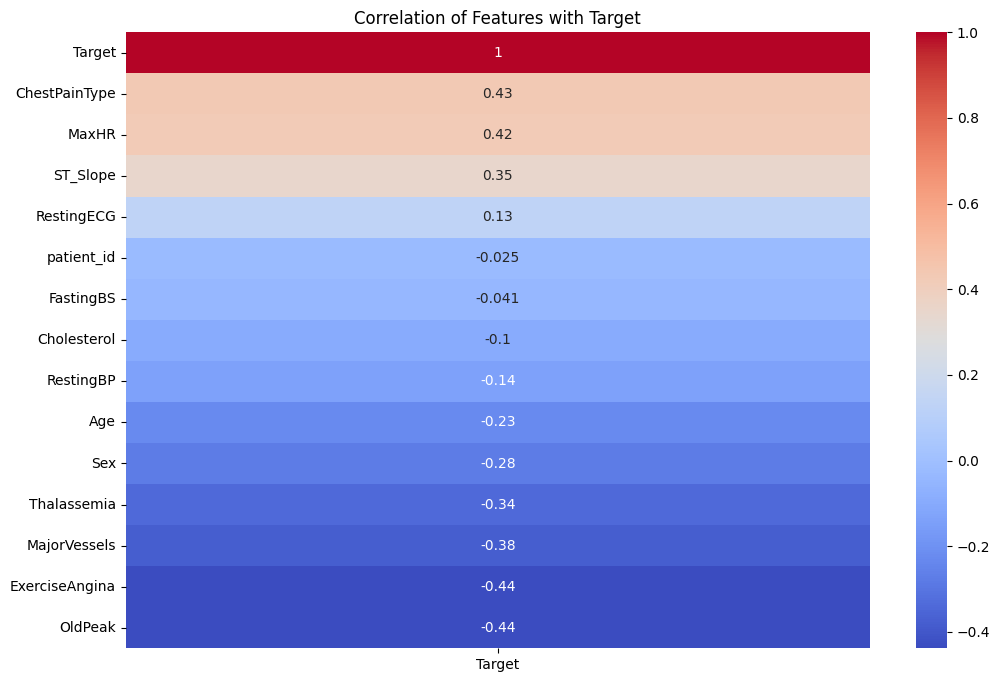

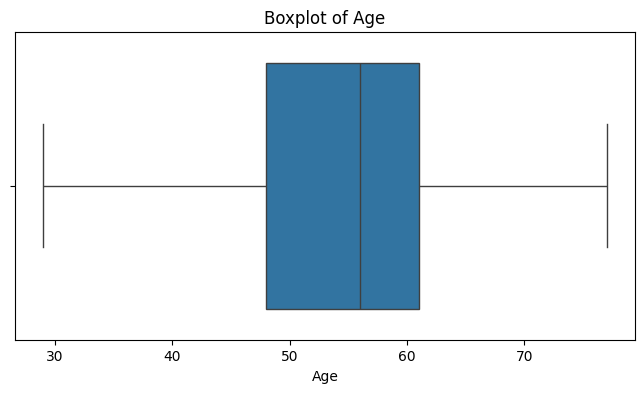

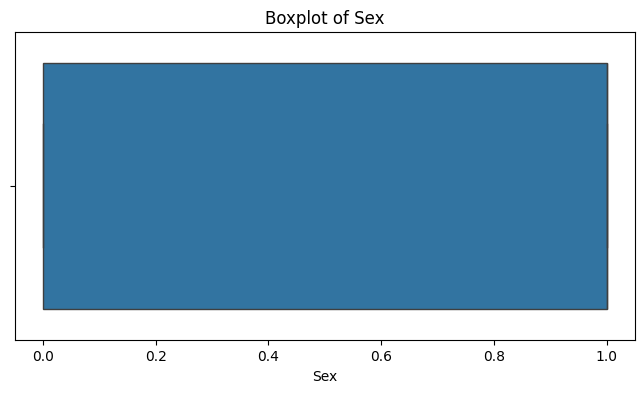

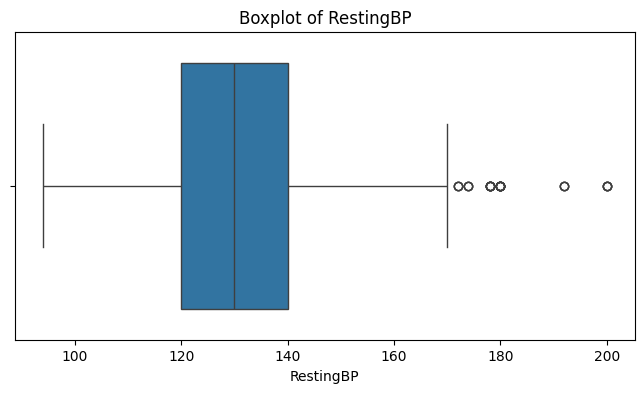

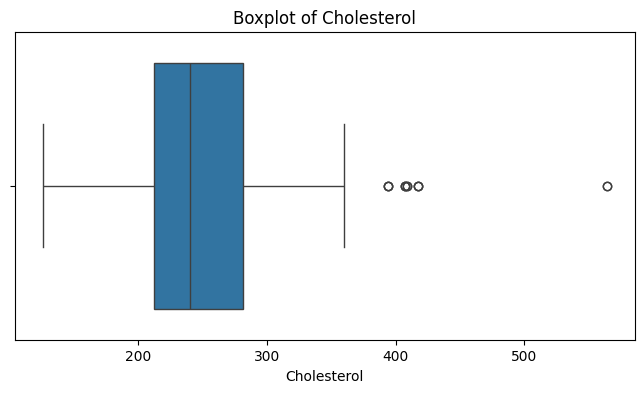

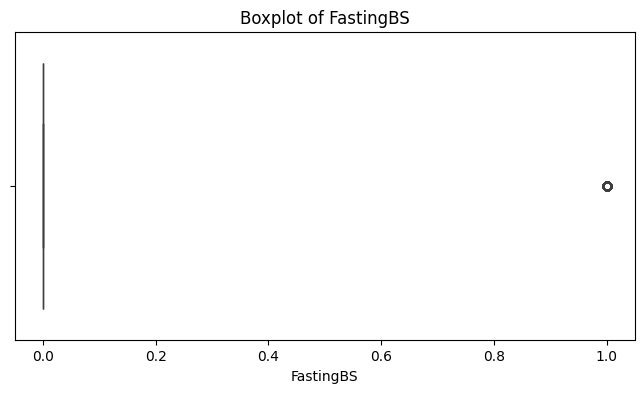

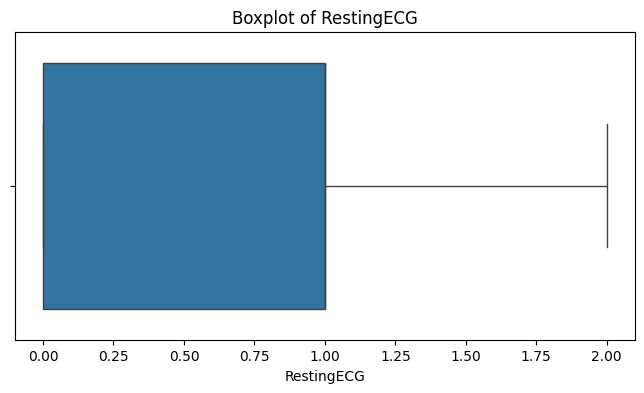

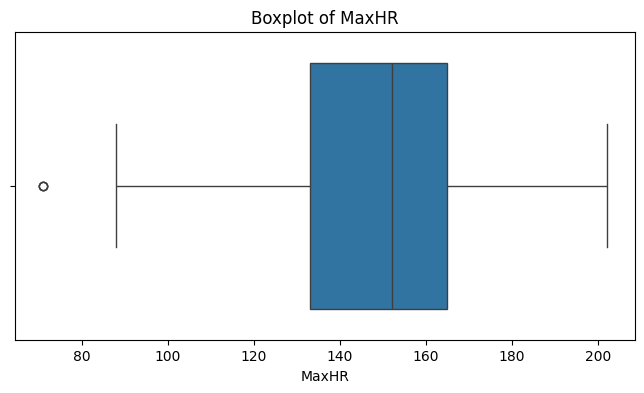

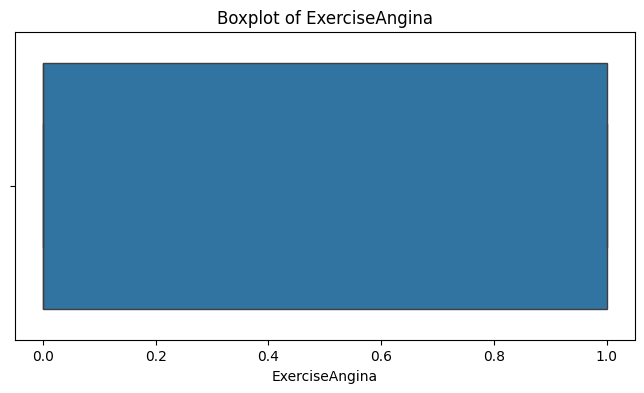

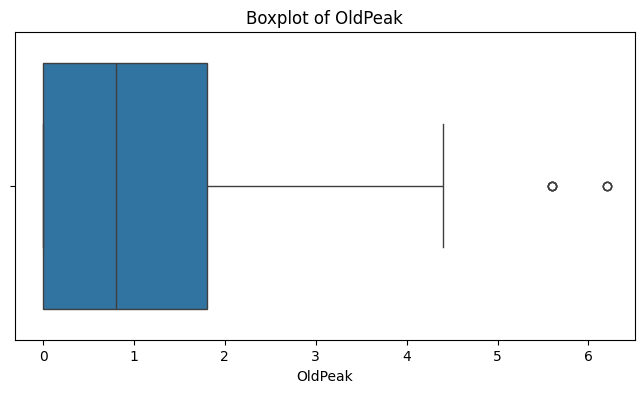

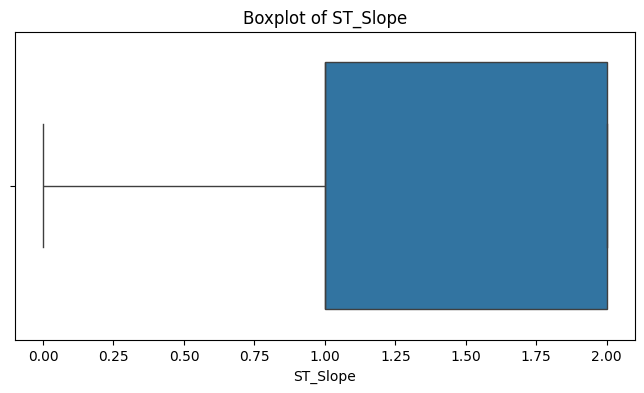

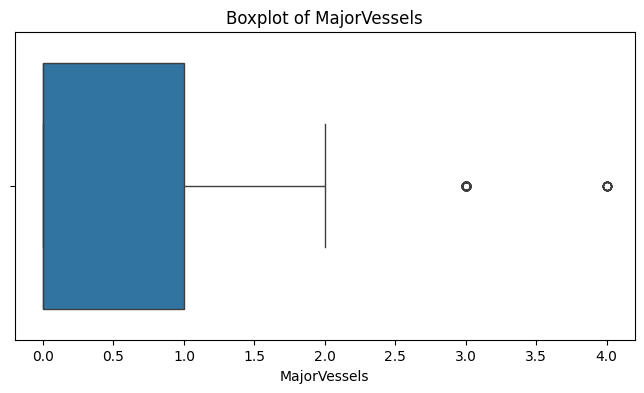

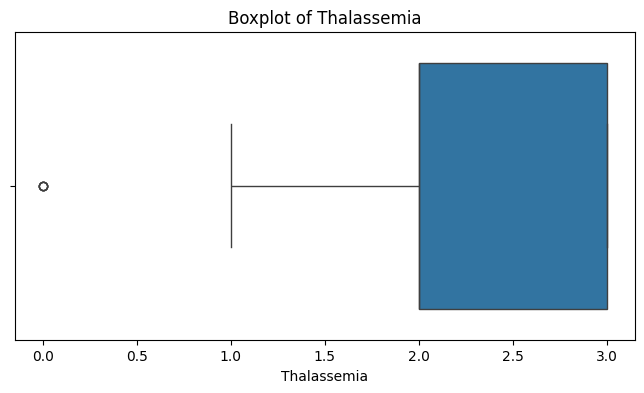

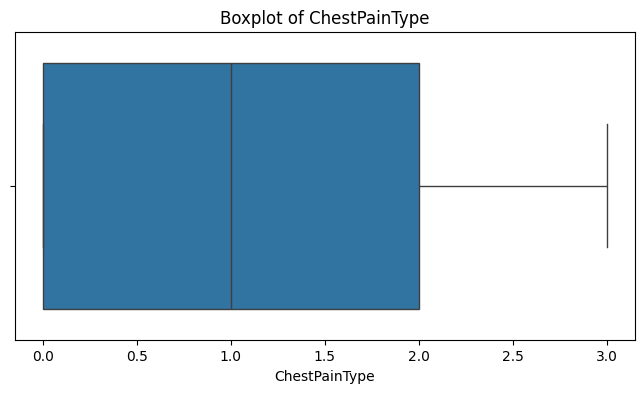


Missing values in training data:
Series([], dtype: int64)

Missing values in testing data:
Series([], dtype: int64)

Feature analysis and missing value checks logged to DagsHub successfully!
🏃 View run Feature Analysis and Missing Values at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0/runs/3a660aabe9144b6faa3aa7e47a35cc54
🧪 View experiment at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

# Start an MLflow run
with mlflow.start_run(run_name="Feature Analysis and Missing Values"):
    # Re-analyze the correlation matrix to focus on feature relationships with Target
    plt.figure(figsize=(12, 8))
    feature_target_correlation = correlation_matrix[['Target']].sort_values(by='Target', ascending=False)
    sns.heatmap(feature_target_correlation, annot=True, cmap="coolwarm", cbar=True)
    plt.title("Correlation of Features with Target")
    # Save and show heatmap
    heatmap_path = "feature_target_correlation.png"
    plt.savefig(heatmap_path)
    plt.show()
    mlflow.log_artifact(heatmap_path)

    # Analyze distributions of numerical features for capped values and outliers
    for column in X_train.columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=X_train[column])
        plt.title(f"Boxplot of {column}")
        plt.xlabel(column)
        # Save and show boxplot
        boxplot_path = f"{column}_boxplot.png"
        plt.savefig(boxplot_path)
        plt.show()
        mlflow.log_artifact(boxplot_path)

    # Check for missing values
    missing_values_train = X_train.isnull().sum()
    missing_values_test = X_test.isnull().sum()

    print("\nMissing values in training data:")
    train_missing_summary = missing_values_train[missing_values_train > 0]
    print(train_missing_summary)
    mlflow.log_param("Missing Values in Training Data", train_missing_summary.to_dict())

    print("\nMissing values in testing data:")
    test_missing_summary = missing_values_test[missing_values_test > 0]
    print(test_missing_summary)
    mlflow.log_param("Missing Values in Testing Data", test_missing_summary.to_dict())

    print("\nFeature analysis and missing value checks logged to DagsHub successfully!")


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np
import mlflow

# Start an MLflow run
with mlflow.start_run(run_name="Logistic Regression Model with Cross-Validation"):
    # 1. Cap outliers in RestingBP and Cholesterol
    def cap_outliers(column, lower_percentile=1, upper_percentile=99):
        lower_bound = np.percentile(column, lower_percentile)
        upper_bound = np.percentile(column, upper_percentile)
        return np.clip(column, lower_bound, upper_bound)

    X_train['RestingBP'] = cap_outliers(X_train['RestingBP'])
    X_train['Cholesterol'] = cap_outliers(X_train['Cholesterol'])
    X_test['RestingBP'] = cap_outliers(X_test['RestingBP'])
    X_test['Cholesterol'] = cap_outliers(X_test['Cholesterol'])
    
    # Log the capping process
    mlflow.log_param("Outliers Capped for RestingBP and Cholesterol", "True")

    # 2. Preprocessing pipeline
    # Identify numerical and categorical columns
    numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'OldPeak']
    categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

    # Preprocessing steps
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # 3. Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ])

    # 4. Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='f1')

    # Log cross-validation results
    print("Cross-validation F1-scores:")
    print(cv_scores)
    print(f"Mean F1-score: {cv_scores.mean():.4f}")
    print(f"Standard Deviation: {cv_scores.std():.4f}")

    mlflow.log_metric("Mean F1-score", cv_scores.mean())
    mlflow.log_metric("F1-score Std Dev", cv_scores.std())
    mlflow.log_param("Cross-validation F1-scores", cv_scores.tolist())
    
    print("Cross-validation results logged to DagsHub successfully!")


Cross-validation F1-scores:
[0.84587814 0.83448276 0.78200692]
Mean F1-score: 0.8208
Standard Deviation: 0.0278
Cross-validation results logged to DagsHub successfully!
🏃 View run Logistic Regression Model with Cross-Validation at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0/runs/41409c70a5ec44de930956f7f7709b82
🧪 View experiment at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
import mlflow

# Start an MLflow run
with mlflow.start_run(run_name="Model Comparison Experiment"):
    # Define models for comparison
    models = {
        'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
        'RidgeClassifier': RidgeClassifier(random_state=42),
        'RandomForestClassifier': RandomForestClassifier(random_state=42, n_estimators=100)
    }

    # Dictionary to store results
    results = {}

    # Iterate over models and perform cross-validation
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='f1')
        results[model_name] = {
            'mean_f1': cv_scores.mean(),
            'std_f1': cv_scores.std(),
            'cv_scores': cv_scores
        }
        
        # Log results for each model
        mlflow.log_metric(f"{model_name}_Mean_F1", cv_scores.mean())
        mlflow.log_metric(f"{model_name}_Std_F1", cv_scores.std())
        mlflow.log_param(f"{model_name}_CV_Scores", cv_scores.tolist())
        
        print(f"Cross-validation F1-scores: {cv_scores}")
        print(f"Mean F1-score: {cv_scores.mean():.4f}")
        print(f"Standard Deviation: {cv_scores.std():.4f}")

    # Display the results
    print("\nSummary of Experiment #2 Results:")
    for model_name, result in results.items():
        print(f"{model_name}: Mean F1 = {result['mean_f1']:.4f}, Std Dev = {result['std_f1']:.4f}")
        mlflow.log_param(f"{model_name}_Summary", {
            "Mean F1": result['mean_f1'],
            "Std Dev F1": result['std_f1']
        })
    
    print("\nModel comparison results logged to DagsHub successfully!")



Training LogisticRegression...
Cross-validation F1-scores: [0.84587814 0.83448276 0.78200692]
Mean F1-score: 0.8208
Standard Deviation: 0.0278

Training RidgeClassifier...
Cross-validation F1-scores: [0.85211268 0.84137931 0.77241379]
Mean F1-score: 0.8220
Standard Deviation: 0.0353

Training RandomForestClassifier...
Cross-validation F1-scores: [0.95890411 0.96402878 0.95438596]
Mean F1-score: 0.9591
Standard Deviation: 0.0039

Summary of Experiment #2 Results:
LogisticRegression: Mean F1 = 0.8208, Std Dev = 0.0278
RidgeClassifier: Mean F1 = 0.8220, Std Dev = 0.0353
RandomForestClassifier: Mean F1 = 0.9591, Std Dev = 0.0039

Model comparison results logged to DagsHub successfully!
🏃 View run Model Comparison Experiment at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0/runs/c05c55d4bfbf4eb6abdf58fbf9c4bebe
🧪 View experiment at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0


In [17]:
import mlflow

# Start an MLflow run
with mlflow.start_run(run_name="Feature Engineering and Logistic Regression"):
    # 1. Create new engineered features
    X_train = X_train.copy()  # Avoid modifying the original data
    X_test = X_test.copy()

    # Calculate new features
    X_train['HeartRateReserve'] = 220 - X_train['Age'] - X_train['MaxHR']
    X_test['HeartRateReserve'] = 220 - X_test['Age'] - X_test['MaxHR']

    X_train['CholesterolToAgeRatio'] = X_train['Cholesterol'] / X_train['Age']
    X_test['CholesterolToAgeRatio'] = X_test['Cholesterol'] / X_test['Age']

    X_train['ExerciseImpactIndex'] = X_train['OldPeak'] * X_train['ST_Slope']
    X_test['ExerciseImpactIndex'] = X_test['OldPeak'] * X_test['ST_Slope']

    # Log new features created
    mlflow.log_param("New Features", [
        "HeartRateReserve",
        "CholesterolToAgeRatio",
        "ExerciseImpactIndex"
    ])
    
    print("\nNew features engineered and added to datasets.")

    # Add new features to the numerical features list
    numerical_features.extend(['HeartRateReserve', 'CholesterolToAgeRatio', 'ExerciseImpactIndex'])

    # 2. Recreate the preprocessing pipeline to include new features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # 3. Test Logistic Regression with new features
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ])

    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='f1')

    # Log cross-validation results
    print("\nCross-validation F1-scores with new features:")
    print(cv_scores)
    print(f"Mean F1-score: {cv_scores.mean():.4f}")
    print(f"Standard Deviation: {cv_scores.std():.4f}")

    mlflow.log_metric("Mean F1-score with New Features", cv_scores.mean())
    mlflow.log_metric("F1-score Std Dev with New Features", cv_scores.std())
    mlflow.log_param("Cross-validation F1-scores with New Features", cv_scores.tolist())

    print("\nFeature engineering and logistic regression results logged to DagsHub successfully!")



New features engineered and added to datasets.

Cross-validation F1-scores with new features:
[0.84697509 0.83448276 0.79037801]
Mean F1-score: 0.8239
Standard Deviation: 0.0243

Feature engineering and logistic regression results logged to DagsHub successfully!
🏃 View run Feature Engineering and Logistic Regression at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0/runs/a13dd1d3e540441a8eecc0acd500e589
🧪 View experiment at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0


In [19]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import mlflow

# Start an MLflow run
with mlflow.start_run(run_name="Feature Selection"):
    # 1. Correlation Threshold
    # Compute the correlation matrix
    correlation_matrix = X_train.corr()
    correlation_threshold = 0.9  # Threshold for high correlation
    correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                correlated_features.add(correlation_matrix.columns[i])

    print("\nFeatures removed due to high correlation:")
    print(correlated_features)
    mlflow.log_param("Features Removed Due to High Correlation", list(correlated_features))

    X_train_corr = X_train.drop(columns=correlated_features)
    X_test_corr = X_test.drop(columns=correlated_features)

    # 2. Feature Importance (Random Forest)
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)

    importances = rf.feature_importances_
    importance_threshold = 0.01  # Features below this threshold will be removed

    important_features = [feature for feature, importance in zip(X_train.columns, importances) if importance > importance_threshold]

    print("\nFeatures selected based on importance threshold:")
    print(important_features)
    mlflow.log_param("Features Selected by Importance", important_features)

    X_train_importance = X_train[important_features]
    X_test_importance = X_test[important_features]

    # 3. Variance Threshold
    # Remove low-variance features
    variance_threshold = 0.01  # Minimum variance required to keep the feature
    selector = VarianceThreshold(threshold=variance_threshold)
    selector.fit(X_train)

    selected_features = X_train.columns[selector.get_support()]
    print("\nFeatures selected based on variance threshold:")
    print(selected_features.tolist())
    mlflow.log_param("Features Selected by Variance Threshold", selected_features.tolist())

    X_train_variance = X_train[selected_features]
    X_test_variance = X_test[selected_features]

    # Summary of selected features from all methods
    print("\nSummary of selected features:")
    print("Correlation Threshold:", X_train_corr.columns.tolist())
    print("Feature Importance:", X_train_importance.columns.tolist())
    print("Variance Threshold:", X_train_variance.columns.tolist())

    mlflow.log_param("Correlation Threshold Features", X_train_corr.columns.tolist())
    mlflow.log_param("Feature Importance Features", X_train_importance.columns.tolist())
    mlflow.log_param("Variance Threshold Features", X_train_variance.columns.tolist())

    print("\nFeature selection process logged to DagsHub successfully!")



Features removed due to high correlation:
{'HeartRateReserve'}

Features selected based on importance threshold:
['Age', 'Sex', 'RestingBP', 'Cholesterol', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'OldPeak', 'ST_Slope', 'MajorVessels', 'Thalassemia', 'ChestPainType', 'HeartRateReserve', 'CholesterolToAgeRatio', 'ExerciseImpactIndex']

Features selected based on variance threshold:
['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'OldPeak', 'ST_Slope', 'MajorVessels', 'Thalassemia', 'ChestPainType', 'HeartRateReserve', 'CholesterolToAgeRatio', 'ExerciseImpactIndex']

Summary of selected features:
Correlation Threshold: ['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'OldPeak', 'ST_Slope', 'MajorVessels', 'Thalassemia', 'ChestPainType', 'CholesterolToAgeRatio', 'ExerciseImpactIndex']
Feature Importance: ['Age', 'Sex', 'RestingBP', 'Cholesterol', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'OldP

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import mlflow

# Start an MLflow run
with mlflow.start_run(run_name="Model Evaluation with Selected Features"):
    # Use features selected by Feature Importance
    selected_features = ['Age', 'Sex', 'RestingBP', 'Cholesterol', 'RestingECG', 'MaxHR', 
                         'ExerciseAngina', 'OldPeak', 'ST_Slope', 'MajorVessels', 
                         'Thalassemia', 'ChestPainType', 'CholesterolToAgeRatio', 
                         'ExerciseImpactIndex']

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    # Log selected features
    mlflow.log_param("Selected Features", selected_features)

    # Preprocessing pipeline for selected features
    preprocessor_selected = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, [col for col in selected_features if col in numerical_features]),
            ('cat', categorical_transformer, [col for col in selected_features if col in categorical_features])
        ]
    )

    # Models for evaluation
    models = {
        'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
        'RandomForestClassifier': RandomForestClassifier(random_state=42, n_estimators=100)
    }

    # Dictionary to store results
    results_selected = {}

    # Train and evaluate models with selected features
    for model_name, model in models.items():
        print(f"\nTraining {model_name} with selected features...")
        pipeline_selected = Pipeline(steps=[
            ('preprocessor', preprocessor_selected),
            ('classifier', model)
        ])
        
        cv_scores = cross_val_score(pipeline_selected, X_train_selected, y_train, cv=3, scoring='f1')
        results_selected[model_name] = {
            'mean_f1': cv_scores.mean(),
            'std_f1': cv_scores.std(),
            'cv_scores': cv_scores
        }
        
        # Log results for each model
        mlflow.log_metric(f"{model_name}_Mean_F1", cv_scores.mean())
        mlflow.log_metric(f"{model_name}_Std_F1", cv_scores.std())
        mlflow.log_param(f"{model_name}_CV_Scores", cv_scores.tolist())
        
        print(f"Cross-validation F1-scores: {cv_scores}")
        print(f"Mean F1-score: {cv_scores.mean():.4f}")
        print(f"Standard Deviation: {cv_scores.std():.4f}")

    # Display summary of results
    print("\nSummary of Experiment #4 Results with Selected Features:")
    for model_name, result in results_selected.items():
        print(f"{model_name}: Mean F1 = {result['mean_f1']:.4f}, Std Dev = {result['std_f1']:.4f}")
        mlflow.log_param(f"{model_name}_Summary", {
            "Mean F1": result['mean_f1'],
            "Std Dev F1": result['std_f1']
        })

    print("\nModel evaluation with selected features logged to DagsHub successfully!")



Training LogisticRegression with selected features...
Cross-validation F1-scores: [0.84697509 0.83044983 0.80139373]
Mean F1-score: 0.8263
Standard Deviation: 0.0188

Training RandomForestClassifier with selected features...
Cross-validation F1-scores: [0.95890411 0.97508897 0.95104895]
Mean F1-score: 0.9617
Standard Deviation: 0.0100

Summary of Experiment #4 Results with Selected Features:
LogisticRegression: Mean F1 = 0.8263, Std Dev = 0.0188
RandomForestClassifier: Mean F1 = 0.9617, Std Dev = 0.0100

Model evaluation with selected features logged to DagsHub successfully!
🏃 View run Model Evaluation with Selected Features at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0/runs/a5525b7932cd48079ea5265402bf8c61
🧪 View experiment at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0


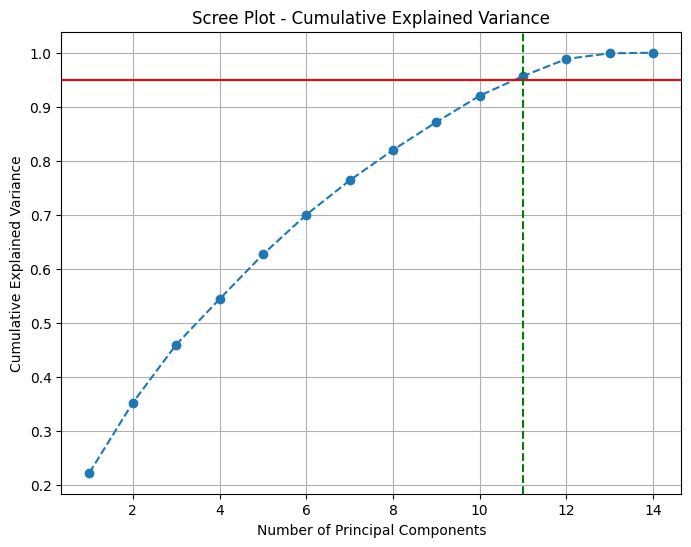


Number of components to retain 95% variance: 11

Cross-validation F1-scores with PCA components:
[0.86597938 0.86111111 0.82154882]
Mean F1-score: 0.8495
Standard Deviation: 0.0199

PCA analysis and logistic regression results logged to DagsHub successfully!
🏃 View run PCA and Logistic Regression at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0/runs/7f022d427d8d4e9f82072cb45dfef80b
🧪 View experiment at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0


In [23]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import mlflow

# Start an MLflow run
with mlflow.start_run(run_name="PCA and Logistic Regression"):
    # Standardize numerical features before PCA
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[selected_features])
    X_test_scaled = scaler.transform(X_test[selected_features])

    # 1. Apply PCA
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Scree Plot
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
    plt.title('Scree Plot - Cumulative Explained Variance')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.axhline(y=0.95, color='r', linestyle='-')  # Threshold at 95% explained variance
    plt.axvline(x=np.argmax(cumulative_variance >= 0.95) + 1, color='g', linestyle='--')  # Number of components for 95% variance
    plt.grid()
    scree_plot_path = "scree_plot.png"
    plt.savefig(scree_plot_path)
    plt.show()
    mlflow.log_artifact(scree_plot_path)

    # Select the number of components (95% variance threshold)
    n_components = np.argmax(cumulative_variance >= 0.95) + 1
    print(f"\nNumber of components to retain 95% variance: {n_components}")
    
    # Log the result with a unique key
    mlflow.log_param("PCA_95_Variance_Components", n_components)

    # Reapply PCA with selected components
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Train Logistic Regression with PCA components
    pipeline_pca = Pipeline(steps=[
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ])

    cv_scores = cross_val_score(pipeline_pca, X_train_pca, y_train, cv=3, scoring='f1')

    # Log results
    print("\nCross-validation F1-scores with PCA components:")
    print(cv_scores)
    print(f"Mean F1-score: {cv_scores.mean():.4f}")
    print(f"Standard Deviation: {cv_scores.std():.4f}")

    # Log metrics and results
    mlflow.log_metric("Mean_F1_Score_PCA", cv_scores.mean())
    mlflow.log_metric("Std_F1_Score_PCA", cv_scores.std())
    mlflow.log_param("PCA_CV_Scores", cv_scores.tolist())

    print("\nPCA analysis and logistic regression results logged to DagsHub successfully!")


In [24]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import mlflow

# Start an MLflow run
with mlflow.start_run(run_name="RFE Feature Selection and Model Evaluation"):
    # Recursive Feature Elimination (RFE)
    log_reg = LogisticRegression(random_state=42, max_iter=5000)  # Increased max_iter to 5000
    rfe = RFE(estimator=log_reg, n_features_to_select=10)  # Select top 10 features

    # Standardize data before applying RFE
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[selected_features])
    X_test_scaled = scaler.transform(X_test[selected_features])

    # Fit RFE on scaled training data
    X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
    X_test_rfe = rfe.transform(X_test_scaled)

    # Get selected features from RFE
    selected_features_rfe = [feature for feature, rank in zip(selected_features, rfe.ranking_) if rank == 1]
    print(f"\nFeatures selected by RFE: {selected_features_rfe}")
    mlflow.log_param("RFE Selected Features", selected_features_rfe)

    # Evaluate the model with selected features
    pipeline_rfe = Pipeline(steps=[
        ('classifier', LogisticRegression(random_state=42, max_iter=5000))  # Increased max_iter to 5000
    ])

    cv_scores_rfe = cross_val_score(pipeline_rfe, X_train_rfe, y_train, cv=3, scoring='f1')

    # Log results
    print("\nCross-validation F1-scores with RFE-selected features:")
    print(cv_scores_rfe)
    print(f"Mean F1-score: {cv_scores_rfe.mean():.4f}")
    print(f"Standard Deviation: {cv_scores_rfe.std():.4f}")

    mlflow.log_metric("Mean F1-score with RFE", cv_scores_rfe.mean())
    mlflow.log_metric("F1-score Std Dev with RFE", cv_scores_rfe.std())
    mlflow.log_param("RFE CV Scores", cv_scores_rfe.tolist())

    print("\nRFE feature selection and model evaluation results logged to DagsHub successfully!")



Features selected by RFE: ['Sex', 'RestingBP', 'Cholesterol', 'MaxHR', 'ExerciseAngina', 'OldPeak', 'ST_Slope', 'MajorVessels', 'Thalassemia', 'ChestPainType']

Cross-validation F1-scores with RFE-selected features:
[0.86006826 0.86111111 0.82119205]
Mean F1-score: 0.8475
Standard Deviation: 0.0186

RFE feature selection and model evaluation results logged to DagsHub successfully!
🏃 View run RFE Feature Selection and Model Evaluation at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0/runs/8fb651b87f2449e485991cf2a5069b62
🧪 View experiment at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0


In [25]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import mlflow

# Start an MLflow run
with mlflow.start_run(run_name="Voting Classifier Evaluation"):
    # Define base models
    log_reg = LogisticRegression(random_state=42, max_iter=5000)
    ridge_clf = RidgeClassifier(random_state=42)
    rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)

    # Create Voting Classifier
    voting_clf = VotingClassifier(
        estimators=[
            ('log_reg', log_reg),
            ('ridge', ridge_clf),
            ('rf', rf_clf)
        ],
        voting='hard'  # Hard voting
    )

    # Perform cross-validation
    cv_scores_voting = cross_val_score(voting_clf, X_train_rfe, y_train, cv=3, scoring='f1')

    # Log cross-validation results
    print("\nCross-validation F1-scores with Voting Classifier:")
    print(cv_scores_voting)
    print(f"Mean F1-score: {cv_scores_voting.mean():.4f}")
    print(f"Standard Deviation: {cv_scores_voting.std():.4f}")

    mlflow.log_metric("Mean F1-score Voting Classifier", cv_scores_voting.mean())
    mlflow.log_metric("F1-score Std Dev Voting Classifier", cv_scores_voting.std())
    mlflow.log_param("Voting Classifier CV Scores", cv_scores_voting.tolist())

    # Train Voting Classifier on the entire training set
    voting_clf.fit(X_train_rfe, y_train)

    # Evaluate on the test set
    test_predictions = voting_clf.predict(X_test_rfe)
    classification_report_str = classification_report(y_test, test_predictions)

    # Log classification report
    print("\nClassification Report on Test Data:")
    print(classification_report_str)
    mlflow.log_text(classification_report_str, "classification_report.txt")

    print("\nVoting Classifier evaluation results logged to DagsHub successfully!")



Cross-validation F1-scores with Voting Classifier:
[0.86394558 0.87285223 0.83660131]
Mean F1-score: 0.8578
Standard Deviation: 0.0154

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.90      0.71      0.79       100
           1       0.77      0.92      0.84       105

    accuracy                           0.82       205
   macro avg       0.83      0.82      0.82       205
weighted avg       0.83      0.82      0.82       205


Voting Classifier evaluation results logged to DagsHub successfully!
🏃 View run Voting Classifier Evaluation at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0/runs/99dbced049734f0f9d34d8728042a7b5
🧪 View experiment at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0


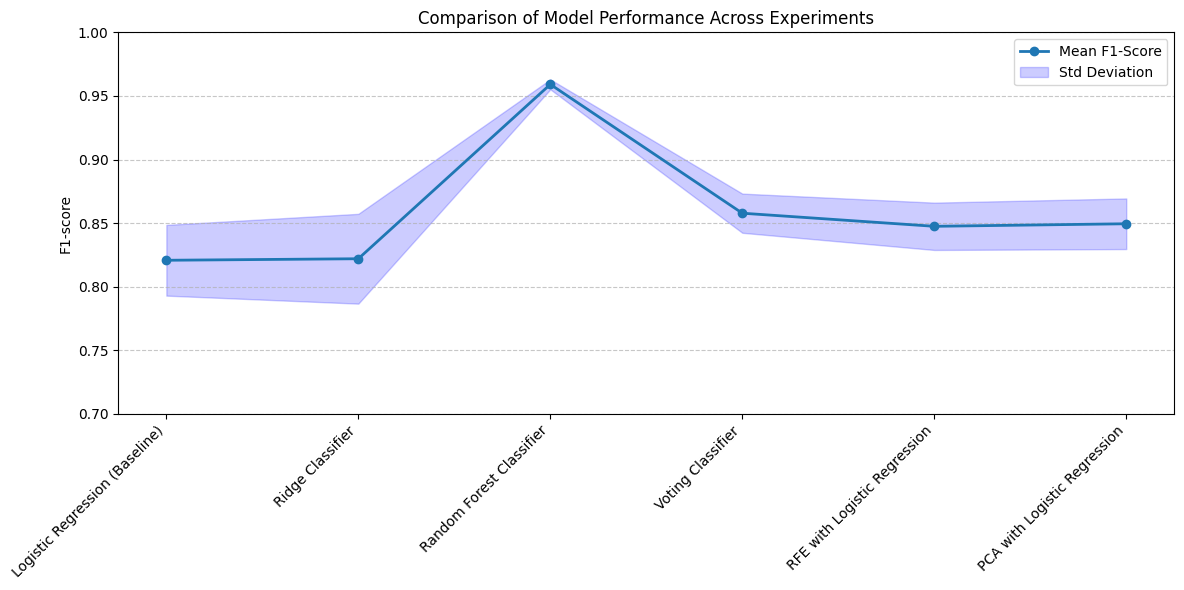


Model performance comparison plot logged to DagsHub successfully!
🏃 View run Model Performance Comparison Plot at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0/runs/3e6543385a27459caca61f6dd42ec7db
🧪 View experiment at: https://dagshub.com/Sudeepthi-Rongali/my-first-repo.mlflow/#/experiments/0


In [26]:
import matplotlib.pyplot as plt
import mlflow

# Start an MLflow run
with mlflow.start_run(run_name="Model Performance Comparison Plot"):
    # Data for the plot
    experiments = [
        'Logistic Regression (Baseline)', 
        'Ridge Classifier', 
        'Random Forest Classifier', 
        'Voting Classifier', 
        'RFE with Logistic Regression', 
        'PCA with Logistic Regression'
    ]

    f1_means = [0.8208, 0.8220, 0.9591, 0.8578, 0.8475, 0.8495]
    f1_stds = [0.0278, 0.0353, 0.0039, 0.0154, 0.0186, 0.0199]

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(experiments, f1_means, marker='o', label='Mean F1-Score', linestyle='-', linewidth=2)
    plt.fill_between(experiments, 
                     [mean - std for mean, std in zip(f1_means, f1_stds)],
                     [mean + std for mean, std in zip(f1_means, f1_stds)],
                     color='blue', alpha=0.2, label='Std Deviation')

    # Adding labels and title
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("F1-score")
    plt.title("Comparison of Model Performance Across Experiments")
    plt.ylim(0.7, 1.0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend()

    # Save and show the plot
    plot_path = "model_performance_comparison.png"
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.show()

    # Log the plot as an artifact
    mlflow.log_artifact(plot_path)

    print("\nModel performance comparison plot logged to DagsHub successfully!")
